### library import

In [1]:
import numpy as np
import pandas as pd
import scipy.misc as scm
from scipy.stats import poisson
import scipy.integrate as integrate
from scipy import signal
import math
import random
from decimal import *
from numba.decorators import jit

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

### theory_with_decimal.py

In [2]:
# 1,準備
# Poisson過程
# 単位時間あたりの到着数 λ
# 時刻tまでにn人が到着する確率
def poisson_probability(n, t, lambda_poisson):
    return float(Decimal(math.e)**(-lambda_poisson * Decimal(t)) * (lambda_poisson * Decimal(t))**Decimal(n) / Decimal(math.factorial(n)))

# Gamma分布
# 時刻tにn人目が到着する確率
def gamma_probability(n, t, lambda_poisson):
    return float(lambda_poisson**n * Decimal(t)**(n - 1) * Decimal(math.e)**(-lambda_poisson * Decimal(t)) / math.factorial(n - 1))


# 時刻Tまでにn人現われるときに， 時刻t(=< T)にm(=< n)人目が到着する確率g(m,n,t,T)
def g(m, n, t, T, lambda_poisson):
    return float(lambda_poisson**Decimal(n) * Decimal(t**(m - 1)) * Decimal((T - t)**(n - m)) * Decimal(math.e)**(-lambda_poisson * Decimal(T)) / (math.factorial(Decimal(m - 1)) * math.factorial(Decimal(n - m))))

# 多数決による判定精度
# n人で多数決を行う場合の判定精度をacc(n)で表す
# 個人の判定精度をpとする
def acc_odd(n, p): # nが奇数2i-1のとき
    i = int((n + 1) / 2)
    acc = 0
    for j in range(i):
        acc += scm.comb(2 * i - 1, j) * p**(2 * i - 1 - j) * (1 - p)**j
    return acc

def acc_even(n, p): # nが偶数2iのとき
    i = int(n / 2)
    acc = 0
    for j in range(i):
        acc += scm.comb(2 * i, j) * p**(2 * i - j) * (1 - p)**j
    acc += scm.comb(2 * i, i) * p**i * (1 - p)**i / 2
    return acc

def acc(n, p):
    if n % 2 == 1:
        return acc_odd(n, p)
    else:
        return acc_even(n, p)

# 2,単純な意見集約法
# 2.1,時刻優先意見集約法
# 時刻tまで待って多数決を行う
# 効用を予測精度と所要時間の差で表す
def time_priority_method(t, w, p, lambda_poisson):
    if t == 0: return 0
    return np.sum(poisson_probability(i, t, lambda_poisson) * acc(i, p) for i in xrange(1,200)) - (w * t)


# 増減を調べる
def inc_and_dec_time_priority_method(w, p, lambda_poisson):
    for t in xrange(1, 1000):
        diff = time_priority_method(t + 1, w, p, lambda_poisson) - time_priority_method(t, w, p, lambda_poisson)
        if diff < 0: return t

# 2.2, 投票数優先意見集約法
# n人集まるまで待って多数決を行う
# 効用を予測精度と所要時間の差で表す
def poll_priority_method(n, w, p, lambda_poisson):
    if n == 0: return 0
    return acc(n, p) - integrate.quad(lambda t: w * t * gamma_probability(n, t, lambda_poisson), 0, 1000)[0]


# 増減を調べる
def inc_and_dec_poll_priority_method(w, p, lambda_poisson):
    for n in xrange(1, 1000):
        diff = poll_priority_method(2 * n + 1, w, p, lambda_poisson) - poll_priority_method(2 * n - 1, w, p, lambda_poisson)
        if diff < 0: return 2 * n - 1

# 2.3, 得票数優先意見集約法
# 先にk票集まった案に決定する
# 効用を予測精度と所要時間の差で表す
def vote_priority_method(k, w, p, lambda_poisson):
    if k == 0: return 0
    utility = 0
    for j in xrange(k, 2 * k):
        value = integrate.quad(lambda t: w * t * gamma_probability(j, t, lambda_poisson), 0, 1000)[0]
        utility += (scm.comb(j - 1, j - k) * p**(k - 1) * (1 - p)**(j - k) * p * (1 - value)) + (scm.comb(j - 1, j - k) * p**(j - k) * (1 - p)**(k - 1) * (1 - p) * -value )
    return utility
    
# 増減を調べる
def inc_and_dec_vote_priority_method(w, p, lambda_poisson):
    for k in xrange(1, 1000):
        diff = vote_priority_method(k + 1, w, p, lambda_poisson) - vote_priority_method(k, w, p, lambda_poisson)
    if diff < 0: return k

# ------------グラフをプロットするメソッド------------
def plot_poisson(time, lambda_poisson):
    x_axis = np.linspace(0, 2 * time * lambda_poisson, 2 * time * lambda_poisson + 1)
    y_axis = [poisson_probability(x, time, lambda_poisson) for x in x_axis]
    plt.title('poisson time: {0} lambda: {1}'.format(time, lambda_poisson))
    plt.xlabel('people')
    plt.ylabel('probability')
    plt.plot(x_axis, y_axis)
    plt.show()

def plot_gamma(people, lambda_poisson):
    x_axis = np.linspace(0, 2 * people / lambda_poisson , 2 * people / lambda_poisson + 1)
    y_axis = [gamma_probability(people, x, lambda_poisson) for x in x_axis]
    plt.title('gamma people: {0} lambda: {1}'.format(people, lambda_poisson))
    plt.xlabel('time')
    plt.ylabel('probability')
    plt.plot(x_axis, y_axis)
    plt.show()

def plot_g(m, n, T, lambda_poisson):
    x_axis = np.linspace(0, T, T + 1)
    y_axis = [g(m, n, x, T, lambda_poisson) for x in x_axis]
    plt.title("g m: {0} n: {1} T:{2} lambda: {3}".format(m, n, T, lambda_poisson))
    plt.xlabel('time')
    plt.ylabel('probability')
    plt.plot(x_axis, y_axis)
    plt.show()

def plot_time_priority(w, p, lambda_poisson, s_time, t_time):
    x_axis = np.linspace(s_time, t_time, t_time - s_time + 1)
    y_axis = []
    y_axis = [time_priority_method(int(x), w, p, lambda_poisson) for x in x_axis]
    plt.title('time priority method weight: {0} person_probability: {1}'.format(w, p))
    plt.xlabel('time')
    plt.ylabel('utility')
    plt.plot(x_axis, y_axis)
    plt.show()

def plot_poll_priority(w, p, lambda_poisson, s_time, t_time):
    x_axis = np.linspace(s_time, t_time, t_time - s_time + 1)
    y_axis = [poll_priority_method(int(x), w, p, lambda_poisson) for x in x_axis]
    plt.title('poll priority method weight: {0} person_probability: {1}'.format(w, p))
    plt.xlabel('poll people')
    plt.ylabel('utility')
    plt.plot(x_axis, y_axis)
    plt.show()

def plot_vote_priority(w, p, lambda_poisson, s_time, t_time):
    x_axis = np.linspace(s_time, t_time, t_time - s_time + 1)
    y_axis = [vote_priority_method(int(x), w, p, lambda_poisson) for x in x_axis]
    plt.title('vote priority method weight: {0} person_probability: {1}'.format(w, p))
    plt.xlabel('require vote people')
    plt.ylabel('utility')
    plt.plot(x_axis, y_axis)
    plt.show()


In [4]:
print "------------- start ---------------"
w = 0.008
p = 0.6
lambda_poisson = Decimal(5)

# %time plot_time_priority(w, p, lambda_poisson, 0, 50)
# %time plot_poll_priority(w, p, lambda_poisson, 0, 50)
# %time plot_vote_priority(w, p, lambda_poisson, 0, 50)

# arr_2 = xrange(20)
# %time fundamental_df = pd.DataFrame({
#     'A: time_priority': [time_priority_method(t, w, p, lambda_poisson) for t in arr_2],
#     'B: poll_priority': [poll_priority_method(n, w, p, lambda_poisson) for n in arr_2],
#     'C: vote_priority': [vote_priority_method(k, w, p, lambda_poisson) for k in arr_2],
# })
# fundamental_df.style.highlight_max()

------------- start ---------------


### theory_without_decimal.py

In [26]:
def poisson_probability(n, t, lambda_poisson):
    return math.e**(-lambda_poisson * t) * (lambda_poisson * t)**n / math.factorial(n)

# P(n, t+1) - P(n, t)
def diff_poisson(n, t, lambda_poisson):
    return math.e**(-lambda_poisson * t) * (lambda_poisson * t)**n * (math.e**-lambda_poisson * lambda_poisson**n - 1) / math.factorial(n)

def gamma_probability(n, t, lambda_poisson):
    return lambda_poisson**n * t**(n - 1) * math.e**(-lambda_poisson * t) / math.factorial(n - 1)

def g(m, n, t, T, lambda_poisson):
    return lambda_poisson**n * t**(m - 1) * (T - t)**(n - m) * math.e**(-lambda_poisson * T) / (math.factorial(m - 1) * math.factorial(n - m))

def acc_odd(n, p):
    i = int((n + 1) / 2)
    acc = 0
    for j in range(i):
        acc += scm.comb(2 * i - 1, j) * p**(2 * i - 1 - j) * (1 - p)**j
    return acc

def acc_even(n, p):
    i = int(n / 2)
    acc = 0
    for j in range(i):
        acc += scm.comb(2 * i, j) * p**(2 * i - j) * (1 - p)**j
    acc += scm.comb(2 * i, i) * p**i * (1 - p)**i / 2
    return acc

def acc(n, p):
    if n % 2 == 1:
        return acc_odd(n, p)
    else:
        return acc_even(n, p)

def time_priority_method(t, w, p, lambda_poisson):
    if t == 0: return 0
    return np.sum(poisson_probability(i, t, lambda_poisson) * acc(i, p) for i in range(1,100)) - (w * t)

def inc_and_dec_time_priority_method(w, p, lambda_poisson):
    for t in range(1, 1000):
        diff = time_priority_method(t + 1, w, p, lambda_poisson) - time_priority_method(t, w, p, lambda_poisson)
        if diff < 0: return t

def poll_priority_method(n, w, p, lambda_poisson):
    if n == 0: return 0
    return acc(n, p) - integrate.quad(lambda t: w * t * gamma_probability(n, t, lambda_poisson), 0, 1000)[0]

def inc_and_dec_poll_priority_method(w, p, lambda_poisson):
    for n in range(1, 1000):
        diff = poll_priority_method(2 * n + 1, w, p, lambda_poisson) - poll_priority_method(2 * n - 1, w, p, lambda_poisson)
        if diff < 0: return 2 * n - 1

def vote_priority_method(k, w, p, lambda_poisson):
    if k == 0: return 0
    utility = 0
    for j in range(k, 2 * k):
        value = integrate.quad(lambda t: w * t * gamma_probability(j, t, lambda_poisson), 0, 500)[0]
        utility += (scm.comb(j - 1, j - k) * p**(k - 1) * (1 - p)**(j - k) * p * (1 - value)) + (scm.comb(j - 1, j - k) * p**(j - k) * (1 - p)**(k - 1) * (1 - p) * -value )
    return utility

def inc_and_dec_vote_priority_method(w, p, lambda_poisson):
    for k in range(1, 1000):
        diff = vote_priority_method(k + 1, w, p, lambda_poisson) - vote_priority_method(k, w, p, lambda_poisson)
        if diff < 0: return k

def method1(t, w, p, lambda_poisson):
    return time_priority_method(t, w, p, lambda_poisson)

def inc_and_dec_method1(w, p, lambda_poisson):
    return inc_and_dec_time_priority_method(w, p, lambda_poisson)

def method2(T1, n, w, p, lambda_poisson):
    if n == 0: return 0
    return np.sum(poisson_probability(i, T1, lambda_poisson) * (acc(i, p) - w * T1) for i in range(0, n)) + integrate.quad(lambda t: (acc(n, p) - w * t) * gamma_probability(n, t, lambda_poisson), 0, T1)[0]

def inc_and_dec_method2(T1, w, p, lambda_poisson):
    for n in range(1, 1000):
        diff = poisson_probability(2 * n, T1, lambda_poisson) * (acc(2 * n, p) - w * T1) + poisson_probability(2 * n - 1, T1, lambda_poisson) * (acc(2 * n - 1, p) - w * T1) + integrate.quad(lambda t: (acc(2 * n + 1, p) - w * t) * gamma_probability(2 * n + 1, t, lambda_poisson), 0, T1)[0] - integrate.quad(lambda t: (acc(2 * n - 1 , p) - w * t) * gamma_probability(2 * n - 1, t, lambda_poisson), 0, T1)[0]
        if diff < 0:
            return 2 * n - 1

def method3(T1, T2, n, w, p, lambda_poisson):
    if n == 0: return 0
    return np.sum(poisson_probability(i, T1, lambda_poisson) * (acc(i, p) - w * T1) for i in range(0, n)) + \
    np.sum(integrate.quad(lambda t: (acc(n, p) - w * t) * g(n, i, t, T1, lambda_poisson), 0, T2)[0] + \
    integrate.quad(lambda t: (acc(n, p) - w * T1) * g(n, i, t, T1, lambda_poisson), T2, T1)[0] for i in range(n, 120))

def inc_and_dec_method3(T1, T2, w, p, lambda_poisson):
    for n in range (1, 1000):
        diff = poisson_probability(2 * n, T1, lambda_poisson) * (acc(2 * n, p) - w * T1) + poisson_probability(2 * n - 1, T1, lambda_poisson) * (acc(2 * n - 1, p) - w * T1) \
        + np.sum(integrate.quad(lambda t: (acc(2 * n + 1, p) - w * t) * g(2 * n + 1, i, t, T1, lambda_poisson), 0, T2)[0] + \
        integrate.quad(lambda t: (acc(2 * n + 1, p) - w * T1) * g(2 * n + 1, i, t, T1, lambda_poisson), T2, T1)[0] for i in range(2 * n + 1, 30)) \
        - np.sum(integrate.quad(lambda t: (acc(2* n - 1, p) - w * t) * g(2 * n - 1, i, t, T1, lambda_poisson), 0, T2)[0] + \
        integrate.quad(lambda t: (acc(2 * n - 1, p) - w * T1) * g(2 * n - 1, i, t, T1, lambda_poisson), T2, T1)[0] for i in range(2 * n - 1, 30))
        if diff < 0:
            return 2 * n - 1

# ------------グラフをプロットするメソッド------------
def plot_poisson(time, lambda_poisson):
    x_axis = np.linspace(0, 2 * time * lambda_poisson, 2 * time * lambda_poisson + 1)
    y_axis = [poisson_probability(x, time, lambda_poisson) for x in x_axis]
    plt.title('poisson time: {0} lambda: {1}'.format(time, lambda_poisson))
    plt.xlabel('people')
    plt.ylabel('probability')
    plt.plot(x_axis, y_axis)
    plt.show()

def plot_gamma(people, lambda_poisson):
    x_axis = np.linspace(0, 2 * people / lambda_poisson , 2 * people / lambda_poisson + 1)
    y_axis = [gamma_probability(people, x, lambda_poisson) for x in x_axis]
    plt.title('gamma people: {0} lambda: {1}'.format(people, lambda_poisson))
    plt.xlabel('time')
    plt.ylabel('probability')
    plt.plot(x_axis, y_axis)
    plt.show()

def plot_g(m, n, T, lambda_poisson):
    x_axis = np.linspace(0, T, T + 1)
    y_axis = [g(m, n, x, T, lambda_poisson) for x in x_axis]
    plt.title("g m: {0} n: {1} T:{2} lambda: {3}".format(m, n, T, lambda_poisson))
    plt.xlabel('time')
    plt.ylabel('probability')
    plt.plot(x_axis, y_axis)
    plt.show()

def plot_time_priority(w, p, lambda_poisson, s_time, t_time):
    x_axis = np.linspace(s_time, t_time, t_time - s_time + 1)
    y_axis = [time_priority_method(int(x), w, p, lambda_poisson) for x in x_axis]
    plt.title('time priority method weight: {0} person_probability: {1}'.format(w, p))
    plt.xlabel('time')
    plt.ylabel('utility')
    plt.plot(x_axis, y_axis)
    plt.show()

def plot_poll_priority(w, p, lambda_poisson, s_time, t_time):
    x_axis = np.linspace(s_time, t_time, t_time - s_time + 1)
    y_axis = [poll_priority_method(int(x), w, p, lambda_poisson) for x in x_axis]
    plt.title('poll priority method weight: {0} person_probability: {1}'.format(w, p))
    plt.xlabel('poll people')
    plt.ylabel('utility')
    plt.plot(x_axis, y_axis)
    plt.show()

def plot_vote_priority(w, p, lambda_poisson, s_time, t_time):
    x_axis = np.linspace(s_time, t_time, t_time - s_time + 1)
    y_axis = [vote_priority_method(int(x), w, p, lambda_poisson) for x in x_axis]
    plt.title('vote priority method weight: {0} person_probability: {1}'.format(w, p))
    plt.xlabel('require vote people')
    plt.ylabel('utility')
    plt.plot(x_axis, y_axis)
    plt.show()

def plot_method1(w, p, lambda_poisson, s_time, t_time):
    x_axis = np.linspace(s_time, t_time, t_time - s_time + 1)
    y_axis = [time_priority_method(int(x), w, p, lambda_poisson) for x in x_axis]
    plt.title('method1 weight: {0} person_probability: {1}'.format(w, p))
    plt.xlabel('time')
    plt.ylabel('utility')
    plt.plot(x_axis, y_axis)
    plt.show()

def plot_method2(T1, w, p, lambda_poisson, s_time, t_time):
    x_axis = np.linspace(s_time, t_time, t_time - s_time + 1)
    y_axis = [method2(T1,int(x), w, p, lambda_poisson) for x in x_axis]
    plt.title('method2 T1: {0} weight: {1} person_probability: {2}'.format(T1, w, p))
    plt.xlabel('poll people')
    plt.ylabel('utility')
    plt.plot(x_axis, y_axis)
    plt.show()

def plot_method3(T1, T2, w, p, lambda_poisson, s_time, t_time):
    x_axis = np.linspace(s_time, t_time, t_time - s_time + 1)
    y_axis = [method3(T1, T2, int(x), w, p, lambda_poisson) for x in x_axis]
    plt.title('method3 T1: {0} T2: {1} weight: {2} person_probability: {3}'.format(T1, T2, w, p))
    plt.xlabel('poll people')
    plt.ylabel('utility')
    plt.plot(x_axis, y_axis)
    plt.show()


------------- start ---------------


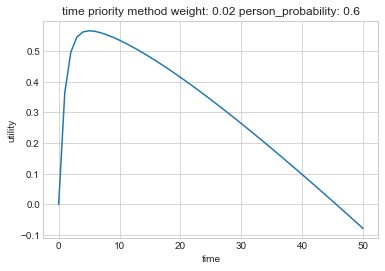

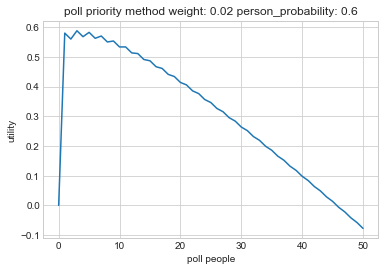

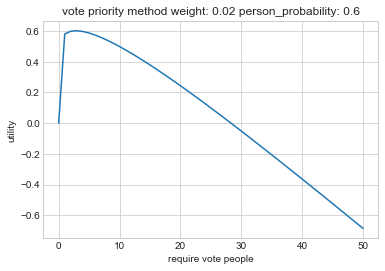

,A: time_priority,B: poll_priority,C: vote_priority
0,0,0,0
1,0.363256,0.58,0.58
2,0.496269,0.56,0.5984
3,0.54522,0.588,0.601248
4,0.562027,0.568,0.596262
5,0.565781,0.58256,0.586355
6,0.563715,0.56256,0.572993
7,0.558677,0.570208,0.557035
8,0.551857,0.550208,0.539039
9,0.543801,0.553432,0.51939


In [86]:
print "------------- start ---------------"
w = 0.02
p = 0.6
lambda_poisson = 1

arr_2 = range(0, 16)
poll_priority_method(10, w, p, lambda_poisson)
plot_time_priority(w, p, lambda_poisson, 0, 50)
plot_poll_priority(w, p, lambda_poisson, 0, 50)
plot_vote_priority(w, p, lambda_poisson, 0, 50)
fundamental_df = pd.DataFrame({
    'A: time_priority': [time_priority_method(int(t), w, p, lambda_poisson) for t in arr_2],
    'B: poll_priority': [poll_priority_method(n, w, p, lambda_poisson) for n in arr_2],
    'C: vote_priority': [vote_priority_method(k, w, p, lambda_poisson) for k in arr_2]
})
fundamental_df.style.highlight_max()

In [27]:
w = 0.02
p = 0.7
lambda_poisson = 1

print "------------時間優先------------"
max_t =  inc_and_dec_time_priority_method(w, p, lambda_poisson)
print max_t
print time_priority_method(max_t, w, p, lambda_poisson)
print "------------------------------------"
print "------------投票数優先------------"
max_n = inc_and_dec_poll_priority_method(w, p, lambda_poisson)
print max_n
print poll_priority_method(max_n, w, p, lambda_poisson)
print "------------------------------------"
print "------------得票数優先------------"
max_k = inc_and_dec_vote_priority_method(w, p, lambda_poisson)
print max_k
print vote_priority_method(max_k, w, p, lambda_poisson)
print "------------------------------------"
print "------------method2------------"
T1_range = range(1, 30)
max_n_list = [inc_and_dec_method2(t1, w, p, lambda_poisson) for t1 in T1_range]
utility_list = []
for i in range(len(max_n_list)):
    n = max_n_list[i]
    utility_list.append(method2(i + 1, n, w, p, lambda_poisson))
print max(utility_list)
print "------------------------------------"
print "------------method3------------"
utility_list = []
T1_range = range(25, 30)
for t1 in T1_range:
    max_n_list = [inc_and_dec_method3(t1, t2, w, p, lambda_poisson) for t2 in range(1, t1+ 1)]
    temp_utility_list = []
    for i in range(len(max_n_list)):
        n = max_n_list[i]
        temp_utility_list.append(method3(t1, i + 1, n, w, p, lambda_poisson))
    print temp_utility_list
    utility_list.append(max(temp_utility_list))
print max(utility_list)
print "------------------------------------"

------------時間優先------------
7
0.714935538741
------------------------------------
------------投票数優先------------
5
0.73692
------------------------------------
------------得票数優先------------
4
0.7664036
------------------------------------
------------method2------------
0.736919999731
------------------------------------
------------method3------------
[0.51077545705835903, 0.62045247537311365, 0.65908943128272024, 0.67267374444172945, 0.67743958013757077, 0.70208783036060296, 0.7140878426367564, 0.7196658224498329, 0.72215749122731943, 0.72900223772696704, 0.73311966656164806, 0.73515389307870393, 0.73612328152064199, 0.73657056602272764, 0.73677090780542709, 0.73685814514833303, 0.73689509054856361, 0.73691029677362996, 0.73691636569285746, 0.73691870398963311, 0.73691956666809066, 0.73691986680242272, 0.73691996219017553, 0.73691998770950573, 0.73691999173458367]
[0.50341786823668666, 0.61774576971013662, 0.65809368991711892, 0.67230743166571061, 0.67730482119934521, 0.7008484545122

In [ ]:
w = 0.01
p = 0.6
lambda_poisson = 4

arr = range(0, 10)

m2_df = pd.DataFrame({
    'a1': [method2(1, n, w, p, lambda_poisson) for n in arr],
    'b2': [method2(2, n, w, p, lambda_poisson) for n in arr],
    'c3': [method2(3, n, w, p, lambda_poisson) for n in arr],
    'd4': [method2(4, n, w, p, lambda_poisson) for n in arr],
    'e5': [method2(5, n, w, p, lambda_poisson) for n in arr],
    'f6': [method2(6, n, w, p, lambda_poisson) for n in arr],
    'g7': [method2(7, n, w, p, lambda_poisson) for n in arr],
    'h8': [method2(8, n, w, p, lambda_poisson) for n in arr],
    'i9': [method2(9, n, w, p, lambda_poisson) for n in arr],
    'j10': [method2(10, n, w, p, lambda_poisson) for n in arr],
    'k11': [method2(11, n, w, p, lambda_poisson) for n in arr],
    'l12': [method2(12, n, w, p, lambda_poisson) for n in arr],
    'm13': [method2(13, n, w, p, lambda_poisson) for n in arr],
    'n14': [method2(14, n, w, p, lambda_poisson) for n in arr],
    'o15': [method2(15, n, w, p, lambda_poisson) for n in arr],
    'p18': [method2(18, n, w, p, lambda_poisson) for n in arr],
    'q21': [method2(21, n, w, p, lambda_poisson) for n in arr],
    'r24': [method2(24, n, w, p, lambda_poisson) for n in arr],
    's27': [method2(27, n, w, p, lambda_poisson) for n in arr],
    't30': [method2(30, n, w, p, lambda_poisson) for n in arr],
})

In [11]:
m2_df.style.highlight_max()

,a1,b2,c3,d4,e5,f6,g7,h8,i9,j10,k11,l12,m13,n14,o15,p18,q21,r24,s27,t30
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.595714,0.597467,0.597499,0.5975,0.5975,0.5975,0.5975,0.5975,0.5975,0.5975,0.5975,0.5975,0.5975,0.5975,0.5975,0.5975,0.5975,0.5975,0.5975,0.5975
2,0.593443,0.594975,0.595,0.595,0.595,0.595,0.595,0.595,0.595,0.595,0.595,0.595,0.595,0.595,0.595,0.595,0.595,0.595,0.595,0.595
3,0.628109,0.639849,0.640476,0.640499,0.6405,0.6405,0.6405,0.6405,0.6405,0.6405,0.6405,0.6405,0.6405,0.6405,0.6405,0.6405,0.6405,0.6405,0.6405,0.6405
4,0.626693,0.637455,0.637982,0.637999,0.638,0.638,0.638,0.638,0.638,0.638,0.638,0.638,0.638,0.638,0.638,0.638,0.638,0.638,0.638,0.638
5,0.638593,0.666321,0.669798,0.670047,0.670059,0.67006,0.67006,0.67006,0.67006,0.67006,0.67006,0.67006,0.67006,0.67006,0.67006,0.67006,0.67006,0.67006,0.67006,0.67006
6,0.638055,0.664299,0.667349,0.66755,0.66756,0.66756,0.66756,0.66756,0.66756,0.66756,0.66756,0.66756,0.66756,0.66756,0.66756,0.66756,0.66756,0.66756,0.66756,0.66756
7,0.640839,0.681566,0.691344,0.692597,0.692701,0.692708,0.692708,0.692708,0.692708,0.692708,0.692708,0.692708,0.692708,0.692708,0.692708,0.692708,0.692708,0.692708,0.692708,0.692708
8,0.640711,0.680199,0.689068,0.690122,0.690203,0.690208,0.690208,0.690208,0.690208,0.690208,0.690208,0.690208,0.690208,0.690208,0.690208,0.690208,0.690208,0.690208,0.690208,0.690208
9,0.641154,0.688643,0.70658,0.710391,0.710884,0.710929,0.710932,0.710932,0.710932,0.710932,0.710932,0.710932,0.710932,0.710932,0.710932,0.710932,0.710932,0.710932,0.710932,0.710932


In [6]:
arr = range(0, 3)

w = 0.01
p = 0.6
lambda_poisson = 1
T1 = 30

m3_df = pd.DataFrame({
    'a1': [method3(T1,1, n, w, p, lambda_poisson) for n in arr],
    'b2': [method3(T1,2, n, w, p, lambda_poisson) for n in arr],
    'c3': [method3(T1,3, n, w, p, lambda_poisson) for n in arr],
    'd4': [method3(T1,4, n, w, p, lambda_poisson) for n in arr],
    'e5': [method3(T1,5, n, w, p, lambda_poisson) for n in arr],
    'f6': [method3(T1,6, n, w, p, lambda_poisson) for n in arr],
    'g7': [method3(T1,7, n, w, p, lambda_poisson) for n in arr],
    'h8': [method3(T1,8, n, w, p, lambda_poisson) for n in arr],
    'i9': [method3(T1,9, n, w, p, lambda_poisson) for n in arr],
    'j10': [method3(T1,10, n, w, p, lambda_poisson) for n in arr],
    'k11': [method3(T1,11, n, w, p, lambda_poisson) for n in arr],
    'l12': [method3(T1,12, n, w, p, lambda_poisson) for n in arr],
    'm13': [method3(T1,13, n, w, p, lambda_poisson) for n in arr],
    'n14': [method3(T1,14, n, w, p, lambda_poisson) for n in arr],
    'o15': [method3(T1,15, n, w, p, lambda_poisson) for n in arr],
    'p16': [method3(T1,16, n, w, p, lambda_poisson) for n in arr],
    'q24': [method3(T1,24, n, w, p, lambda_poisson) for n in arr],
    'r26': [method3(T1,26, n, w, p, lambda_poisson) for n in arr],
    's28': [method3(T1,28, n, w, p, lambda_poisson) for n in arr],
    't30': [method3(T1,30, n, w, p, lambda_poisson) for n in arr],
})

In [7]:
m3_df.style.highlight_max()

,a1,b2,c3,d4,e5,f6,g7,h8,i9,j10,k11,l12,m13,n14,o15,p16,q24,r26,s28,t30
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.486994,0.553459,0.577055,0.585421,0.588383,0.58943,0.589799,0.58993,0.589975,0.589991,0.589997,0.589999,0.59,0.59,0.59,0.59,0.59,0.59,0.59,0.59
2,0.377666,0.471732,0.528719,0.557289,0.570365,0.576034,0.578404,0.579369,0.579754,0.579906,0.579964,0.579986,0.579995,0.579998,0.579999,0.58,0.58,0.58,0.58,0.58


### main

In [ ]:
sns.set_style("whitegrid")
m = modeling()
pg = plotGraph()

w = 0.003
p = 0.6
lambda_poisson = 3

# print "------------時間優先------------"
# print m.inc_and_dec_time_priority_method(w, p, lambda_poisson)
# print m.time_priority_method(m.inc_and_dec_time_priority_method(w, p, lambda_poisson), w, p, lambda_poisson)
# print "------------------------------------"
# print "------------投票数優先------------"
# print m.inc_and_dec_poll_priority_method(w, p, lambda_poisson)
# print m.poll_priority_method(m.inc_and_dec_poll_priority_method(w, p, lambda_poisson), w, p, lambda_poisson)
# print "------------------------------------"
# print "------------得票数優先------------"
# print m.inc_and_dec_vote_priority_method(w, p, lambda_poisson)
# print m.vote_priority_method(m.inc_and_dec_vote_priority_method(w, p, lambda_poisson), w, p, lambda_poisson)
# print "------------------------------------"
# print "------------方法1------------"
# print m.inc_and_dec_method1(w, p, lambda_poisson)
# print m.method1(m.inc_and_dec_method1(w, p, lambda_poisson), w, p, lambda_poisson)
# print "------------------------------------"
# print "------------方法2------------"
# print m.inc_and_dec_method2(50, w, p, lambda_poisson)
# print m.method2(50, m.inc_and_dec_method2(50, w, p, lambda_poisson), w, p, lambda_poisson)
# print "------------------------------------"
# print "------------方法3------------"
# print m.inc_and_dec_method3(40, 20, w, p, lambda_poisson)
# print m.method3(40, 20, m.inc_and_dec_method3(40, 20, w, p, lambda_poisson), w, p, lambda_poisson)
# print "------------------------------------"
# print "------------方法4------------"
# print m.inc_and_dec_method4(3, w, p, lambda_poisson)
# print m.method4(3, m.inc_and_dec_method4(3, w, p, lambda_poisson), w, p, lambda_poisson)
# print "------------------------------------"


In [ ]:
# sns.set_style("whitegrid")
# pg = PlotGraph(50, 2)
# pg.plot_error_possibility_graph(5)
# pg.plot_error_possibility_graph_by_people_num()
# pg.plot_utility_possibility_average_graph(11, 13, 17, 0.5)
# pg.plot_utility_possibility_variance_graph(11, 13, 17, 0.5)
# pg.plot_utility_weight_average_graph(0.7, 11, 13, 17)
# pg.plot_utility_weight_variance_graph(0.7, 11, 13, 17)
# pg.plot_utility_possibility_average_graph_for_single_method(0.5)
# pg.plot_utility_possibility_variance_graph_for_single_method(0.5)
# pg.plot_utility_weight_average_graph_with_uniform_distribution(50, 50, 11, 13, 17)
# pg.plot_utility_weight_variance_graph_with_uniform_distribution(50, 50, 11, 13, 17)
# pg.plot_utility_weight_average_graph_with_uniform_distribution_for_single_method(50, 50)
# pg.plot_utility_weight_variance_graph_with_uniform_distribution_for_single_method(50, 50)

### テスト

In [ ]:
m = modeling()

# integrate g and poisson should be same
# def temp_f(t):
#     return m.g(4,10,t,5,2)
# value, abserr = integrate.quad(temp_f, 0, 5)
# print value
# print m.poisson_probability(10,5,2)
# print "--------------------------------------------------"

# # p_sum plus g_value should be 1.0
# p_sum = 0
# for i in range(0, 50):
#     p_sum += m.poisson_probability(i, 20, 3)
# print p_sum
# def test_g(t):
#     return m.trial_g(50, t, 20, 3)
# g_value, abserr = integrate.quad(test_g, 0, 20)
# print g_value
# print "--------------------------------------------------"

# # method2 p_sum should be 1.0
# def method2_p_sum(T1, n, w, lambda_poisson):
#     p_sum = 0
#     for i in range(0, n):
#         p_sum += m.poisson_probability(i, T1, lambda_poisson)
#     # 積分を行う
#     value, abserr = integrate.quad(lambda t: m.gamma_probability(n, t, lambda_poisson), 0, T1)
#     p_sum += value
#     return p_sum
# print method2_p_sum(20, 10, 0.02, 1)
# print "--------------------------------------------------"

# method3 p_sum should be 1.0
# def method3_p_sum(T1, T2, n, w, lambda_poisson):
#     p_sum = 0
#     for i in range(0, n):
#         p_sum += m.poisson_probability(i, T1, lambda_poisson)
#     for i in range(n, 100):
#         value_1, abserr = integrate.quad(lambda t: m.g(n, i, t, T1, lambda_poisson), 0, T2)
#         value_2, abserr = integrate.quad(lambda t: m.g(n, i, t, T1, lambda_poisson), T2, T1)
#         p_sum += value_1
#         p_sum += value_2
#     return p_sum
# print method3_p_sum(30, 14, 10, 0.02, 1)
# print "--------------------------------------------------"

# vote priority method acc (頭がこんがらがったので確かめ)
# def vote_priority_method(k, p):
#     if k == 0: return 0
#     acc = 0
#     for j in range(k, 2 * k):
#         acc += scm.comb(j - 1, j - k) * p**(k - 1) * (1 - p)**(j - k) * p
#     return acc
# print vote_priority_method(1, 0.9)
# print "--------------------------------------------------"

# method4 p_sum should be 1.
# def method4_p_sum(T1, k, p, lambda_poisson):
#     if k == 0: return 0
#     p_sum = 0
#     for i in range(0, k):
#         for j in range(i, 2 * i):
#             p_sum += m.poisson_probability(j, T1, lambda_poisson) * (scm.comb(j - 1, j - i) * p**(i - 1) * (1 - p)**(j - i) * p)
#     # ----被積分関数を定義----
#     def integrand_for_method4(t):
#         integrand = 0
#         for j in range(k, 2 * k):
#             integrand += m.gamma_probability(j, t, lambda_poisson) * (scm.comb(j - 1, j - k) * p**(k - 1) * (1 - p)**(j - k) * p)
#         return integrand
#     # --------終わり--------
#     #積分を行う
#     value, abserr = integrate.quad(integrand_for_method4, 0, T1)
#     p_sum += value
#     return p_sum
# print method4_p_sum(20, 30, 0.9, 1)